# **15688 Final Project: Yelp Rating Analysis**

**Authors**:<br> 
Jiahui Cai<br>
Yingtian Zhu<br>
Wenting Zhao

# Problem Statement
When thinking about Yelp rating, what immediately props out is the five-star image partially filled with customer input scoring. Given that there are many other types of information available such as business features and characteristics of reviews, a question is raised: is rating a standalone metric, or does it have a relationship with the other information?

This project implements a comprehensive analysis of Yelp restaurant ratings on what business features and how the characteristics of reviews impact rating.

# Motivation
We want to analyze the Yelp business data and review data to get more insights about the relationship between reviews and different factors, such as transctions, price. We also want to know does different gender groups have bias on reviews and ratings.

From the data perspective, in order to address the question raised, we need to work with different types of data: ratings are numerical, business metrics such as transactions and price range are categorical, whereas reviews are unstructured text. From the project and learning perspective, dealing with various types of data requires us to first select the appropriate tools and then reason our findings from different types of outcomes. As a high-level overview, we will be using API data extraction, visualization, categorical regression, and sentiment analysis.


#Data
We obtain business details and reviews from Yelp API. 
#### What to select: 
To collect a dataset of reasonable size while capturing geographical variance, we randomly pick 1000 restaurants for each of 9 metropolitan cities across the U.S. The cities selected are: New York, Boston, Chicago, Houston, Austin, San Francisco, Seattle, Atlanta, and Miami

#### How to obtain: 
**Source**: Yelp API<br>
**Step 1**: Obtain business details from https://api.yelp.com/v3/businesses/search, with city as selection criteria<br>
**Step 2**: Obtain business reviews from "https://api.yelp.com/v3/businesses/{id}/reviews"<br>
.


# import libraries

In [1]:
import io, time, json
import requests
from pathlib import Path
import tqdm
from tqdm import tqdm
import pandas as pd 
import numpy as np 
pd.set_option('display.max_colwidth', 200)
import re
import pickle
import nltk
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interactive
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf

# Query Yelp API for Data

In [ ]:
#define functions to get business data from Yelp Api
def read_api_key():
    """
    Read the Yelp API Key from file.
    """
    api_key = "pJUWxhOboVgcg6Ja8fN218nQXc6nLyTLPCIRkOEuZZT9_fTyfbhy6H9DBLYASUitrryZG5kwPCKzHmAvgmQUFP1-RwxQbLDW-N-zdCvSdcm1OVu6O5VZpMbIxpdqXXYx"
    return api_key

def yelp_search(api_key, query):
    """
    Make an authenticated request to the Yelp API.
    """
    headers = {'Authorization':'Bearer {}'.format(api_key)}
    url = 'https://api.yelp.com/v3/businesses/search'
    print("yelp_search query:", query)
    params = {'location':query}
    r = requests.get(url, params=params, headers=headers)
    r_json = json.loads(r.content)
    return r_json['total'], r_json['businesses'] 

def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.
    """
    headers = {'Authorization':'Bearer {}'.format(api_key)}
    url = 'https://api.yelp.com/v3/businesses/search'
    params = {'location':query,'categories':'restaurants'}
    r = requests.get(url, params=params, headers=headers)
    print("allrestaurantsquery: ", query, "r: ",r)
    data = json.loads(r.content)
    print(data)
    total = data['total']
    res = data['businesses'] 
    while len(res) < total:
        print(len(res),total)
        params = {'categories':'restaurants','location':query,'offset':len(res)}
        r = requests.get(url, params=params, headers=headers)
        data = json.loads(r.content)
        try:
            res.extend(data['businesses'])
        except:
            print(data)
            break
        time.sleep(0.3)
    return res

def parse_api_response(data):
    """
    Parse Yelp API results to create business dictionary
    """
    
    business_dic= {}
    for i in data:
        business_dic[i['id']] = i
    return business_dic


In [ ]:
api_key = read_api_key()
#define 9 major cities in US
Queries = ['New York', 'Boston', 'Chicago', 'Houston','Austin', 'San Francisco', 'Seattle', 'Atlanta','Miami']
#define functions to get business reviews from Yelp Api

def get_review(api_key,business_id):
    """
    get reviews from yelp api
    """
    headers = {'Authorization':'Bearer {}'.format(api_key)}
    url = "https://api.yelp.com/v3/businesses/{}/reviews".format(business_id)
    r = requests.get(url, headers=headers)
    r_json = json.loads(r.content)
    try:
        tmp = r_json['reviews']
        return tmp 
    except:
        return []
    
def all_reviews(api_key, business_dict):
    """
    add reviews as elements in business dict 
    """
    for id in business_dict:
        business_dict[id]['reviews'] = get_review(api_key,id)
    return business_dict

def get_city_review(api_key,city_list):
    """
    loop through the city list and create a city dic, city as key, and all the restaurants info as value
    """
    city_dic={}
    for city in city_list:
        business = all_restaurants(api_key,city)
        business_dic = parse_api_response(business)
        city_dic[city] = all_reviews(api_key,business_dic)
    return city_dic

city_dic = get_city_review(api_key, Queries)
city_dic

In [ ]:
#store the dictionary as a pickle file 
pickle_out = open("city_dic_all.pickle","wb")
pickle.dump(city_dic, pickle_out)
pickle_out.close()

# Part 1: Transactions Analysis

In [3]:
pickle_in = open("city_dic_all.pickle","rb")
example_dict = pickle.load(pickle_in)

According to Yelp, transactions are defined as the list of Yelp services that the business is registered for. Current supported values are pickup, delivery and restaurant_reservation.

In this part, we inspect how transactions impact rating. Restaurants can support None or any combination of 3 types of transactions: pickup, delivery, and reservation. A new boolean variable is created to indicate whether or not each restaurant supports at least on transaction.


In [4]:
#define the function to create a pandas df for transactions analysis
def create_transactions_df(raw_dict):
    Cities = list()
    business = list()
    transactions = list()
    num_transactions = list()
    ratings = list()
    for city in example_dict:
        for bid in example_dict[city]:
            Cities.append(city)
            business.append(bid)
            transactions.append(int(len(example_dict[city][bid]["transactions"]) != 0))
            num_transactions.append(int(len(example_dict[city][bid]["transactions"])))
            ratings.append(example_dict[city][bid]["rating"])
    df = pd.DataFrame()
    df["City"] = Cities
    df["Business_ID"] = business
    df["Has Transaction"] = transactions
    df["Num Transactions"] = num_transactions
    df["Rating"] = ratings
    return df

In [5]:
transactions_df = create_transactions_df(example_dict)

In [6]:
# Define a function which utilizes plotly to create a pie chart for percentages of restaurants
# with and without transactions for the input city
def pie_chart_transactions(city):
    keys = ['W/ Transactions', 'W/O Transactions']
    values = [dict(transactions_df.loc[transactions_df["City"] == city, "Has Transaction"].value_counts())[1], 
              dict(transactions_df.loc[transactions_df["City"] == city, "Has Transaction"].value_counts())[0]]
    fig = go.Figure(data=[go.Pie(labels=keys, 
                                 values=values, 
                                 marker=dict(colors=['#0000FF','#FF0000']))],
                    layout=go.Layout(title=go.layout.Title(text="Percetange of Yelp Restaurants With and Without Transactions in "
                                                          + city),
                                     width = 800, height = 400))
    fig.show(renderer="notebook_connected")

In [7]:
# Define a function to implement Ipython widgets for interaction of input city
# in the pie chart defined above
def unique_city_options(df):
    unique_cities = sorted(list(set(list(df["City"]))))
    initial_city = sorted(list(set(list(df["City"]))))[0]
    city_options = widgets.Dropdown(options=unique_cities,
                                value=initial_city,
                                description='City: ')
    return city_options

In [8]:
# Define a function which connects the pie chart with the interactive widget
# to yield an interactive pie chart
def visualize_city_transactions(col_options):
    '''
    Call interactive() function from ipywidgets to connect the pie chart with interactive drop down list of columns
    col_options: an ipywidgets object of a drop down list of columns
    '''
    interactive_plot = interactive(pie_chart_transactions, city = col_options)
    return interactive_plot

In [9]:
#display(visualize_city_transactions(unique_city_options(transactions_df)))
#this is interactive part

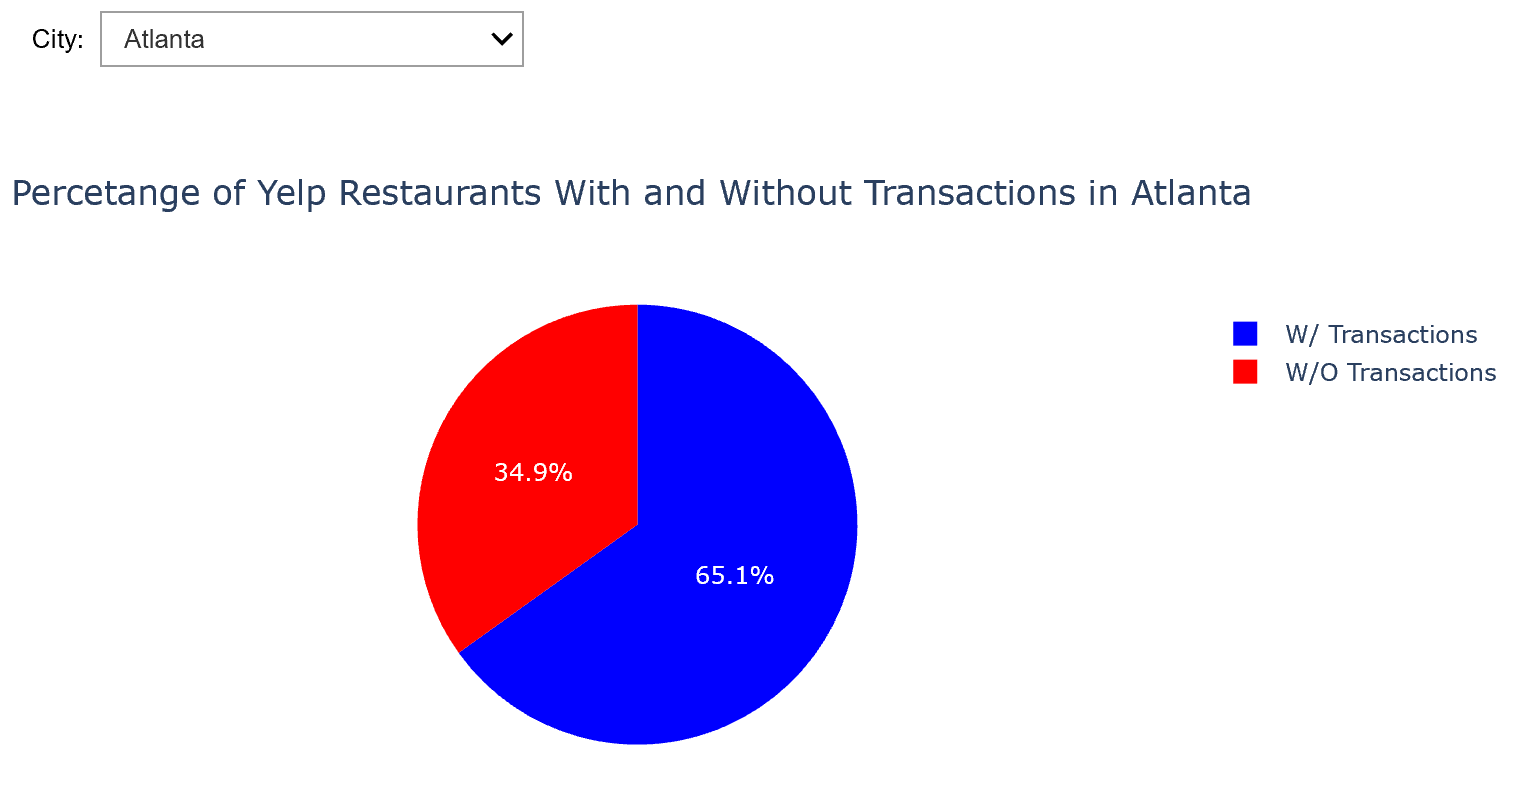

In [12]:
from IPython.display import Image
Image(filename='Altanta.png') 

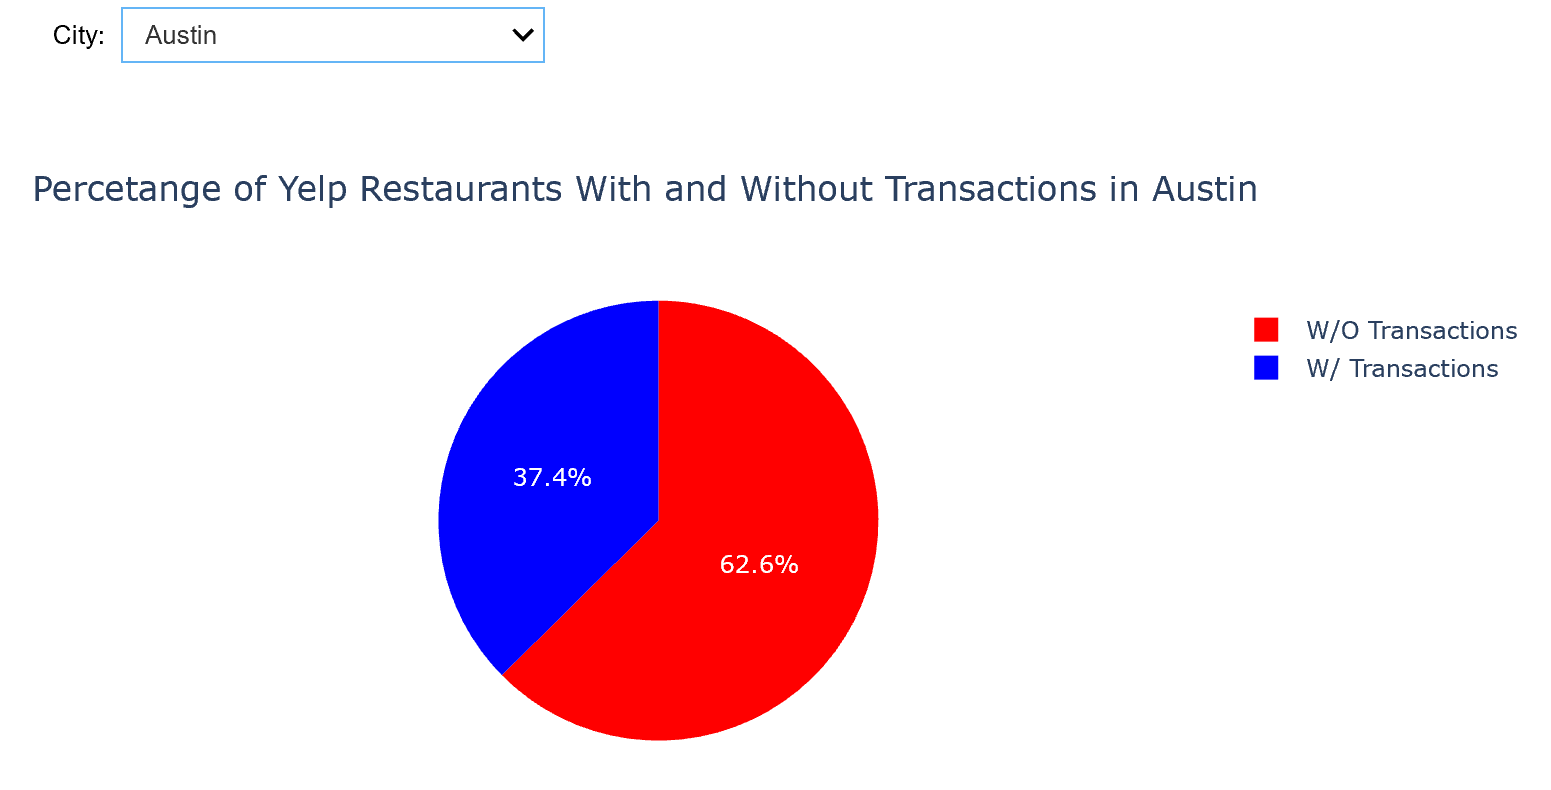

In [13]:
Image(filename='Austin.png') 

This interactive pie chart displays the proportion of restaurants with and without transactions. Such percentage differs significantly across cities. For example, in Atlanta, 65.1% of restaurants picked offer transactions, whereas only 37.4% of restaurants picked do so in Austin.

Next, we look at how mean ratings for restaurants vary based on the existence of transactions across cities. 2 lists are created to store the average ratings for restaurants with and without transactions in each city.

In [14]:
# Define a function which creates a line chart of two lines:
# one for average rating for restaurants with transactions across cities,
# another for average rating for restaurants without transactions across cities
def visualize_rating_by_transaction_chart(transactions_df):
    cities = sorted(list(set(list(transactions_df["City"]))))
    x1 = [transactions_df.loc[(transactions_df["City"] == i) & (transactions_df["Has Transaction"] == 1), "Rating"].mean() for i in cities]
    x0 = [transactions_df.loc[(transactions_df["City"] == i) & (transactions_df["Has Transaction"] == 0), "Rating"].mean() for i in cities]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=cities, y=x0, name = "W/O Transactions"))
    fig.add_trace(go.Scatter(x=cities, y=x1, name = "W Transactions"))
    fig.update_layout(
        title="Mean Rating for Restaurants W/ and W/O Transactions",
        xaxis_title="City",
        yaxis_title="Mean Rating")
    fig.show()

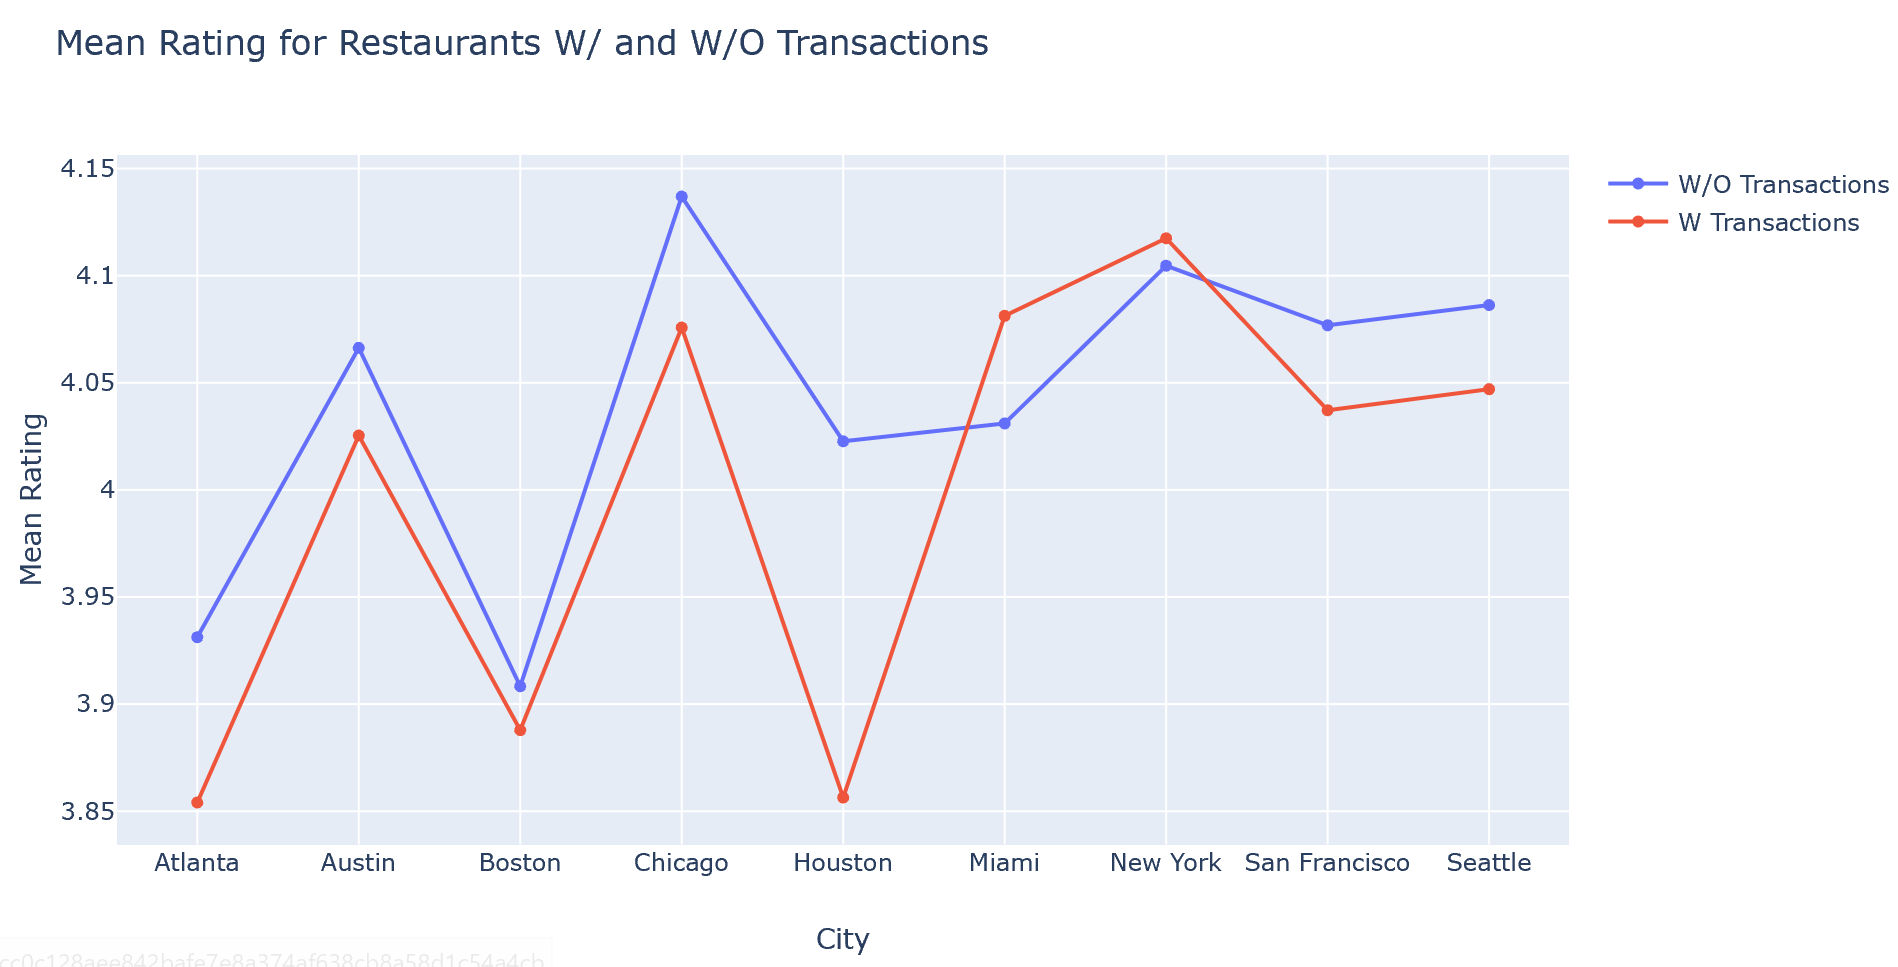

In [15]:
#visualize_rating_by_transaction_chart(transactions_df)
Image(filename='result.png') 

In this line chart, 7 out of 9 target cities have higher average ratings when businesses do not support any transactions. The largest gap exists for Houston, in which the mean rating for restaurants without transactions is about 0.2 higher than that for restaurants with transactions. 

## Key Takeaway for Part 1
The result from the line chart above may be counter-intuitive at a first glance. It makes more sense that restaurants that offer more services would provide more convenience for customers and therefore have better ratings. However, the existence of additional services means that customer ratings are now depending on more aspects that may or may not be controllable by the restaurants. For example, if a restaurant offers delivery service, it may get low ratings because of delays and spills in third-party delivery services. 

# Part 2: Price and Location Analysis

We analyze the relationship between rating and price. We learned that rating is negatively correlated with price. After breaking down the price, we noticed the ratings are higher for both cheap food and luxury meals, while the rating for normal food is lower.

In [16]:
def create_price_location_df(raw_dict):  
    """
    raw_dict: with city as key of the dict
    """
    res = []
    for city in raw_dict:
        all_business = raw_dict[city] # a dict containing all restaurants we can retrieve data in the city. 
        for business in all_business:
            try:
                tmp = all_business[business]
                name = tmp['name']
                price = tmp['price']
                location = tmp['location']
                rating = tmp['rating'] 
                review_count = tmp['review_count']
                res.append([name,price,city,rating,review_count])
            except:
                pass
    df = pd.DataFrame(res, columns=['name','price','city','rating','number of rating'])
    df['price_ordinal'] = df['price'].apply(lambda x: len(x))
    return df

In [17]:
price_location_df = create_price_location_df(example_dict)

In [18]:
price_location_df.corr('spearman') # to calculate the ranking correlation for ordinal/numerical variables

,rating,number of rating,price_ordinal
rating,1.000000,-0.167017,-0.120244
number of rating,-0.167017,1.000000,0.274609
price_ordinal,-0.120244,0.274609,1.000000


In [19]:
price_location_df.groupby(['price','city']).mean()['rating']

price  city         
$      Atlanta          4.000000
       Austin           4.139946
       Boston           4.044393
       Chicago          4.252747
       Houston          4.089069
       Miami            4.166667
       New York         4.221739
       San Francisco    4.163793
       Seattle          4.197095
$$     Atlanta          3.834278
       Austin           3.956960
       Boston           3.825980
       Chicago          4.055556
       Houston          3.897535
       Miami            4.028369
       New York         4.093844
       San Francisco    4.034039
       Seattle          4.028889
$$$    Atlanta          3.866197
       Austin           4.132075
       Boston           3.847328
       Chicago          4.056522
       Houston          3.927632
       Miami            3.938462
       New York         4.085366
       San Francisco    3.969925
       Seattle          4.000000
$$$$   Atlanta          4.111111
       Austin           4.250000
       Boston         

In [20]:
price_location_df.groupby(['price']).mean()['rating']

price
$       4.135892
$$      3.974300
$$$     3.982245
$$$$    4.155556
Name: rating, dtype: float64

In [21]:
price_location_df.groupby(['city']).describe()['rating']

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Atlanta,984.0,3.872459,0.411240,2.5,3.5,4.0,4.0,5.0
Austin,975.0,4.037949,0.423993,2.5,4.0,4.0,4.5,5.0
Boston,979.0,3.882022,0.415231,2.5,3.5,4.0,4.0,5.0
Chicago,999.0,4.094595,0.325612,3.0,4.0,4.0,4.5,5.0
Houston,980.0,3.948469,0.424779,2.5,3.5,4.0,4.0,5.0
Miami,968.0,4.048037,0.424820,3.0,4.0,4.0,4.5,5.0
New York,998.0,4.112224,0.303657,3.0,4.0,4.0,4.5,5.0
San Francisco,998.0,4.055110,0.320589,3.0,4.0,4.0,4.0,5.0
Seattle,995.0,4.069849,0.350187,3.0,4.0,4.0,4.5,5.0


In [22]:
price_location_df.groupby(['price_ordinal']).describe()['rating']

,count,mean,std,min,25%,50%,75%,max
price_ordinal,,,,,,,,
1,1928.0,4.135892,0.386189,3.0,4.0,4.0,4.5,5.0
2,5895.0,3.974300,0.388994,2.5,3.5,4.0,4.0,5.0
3,873.0,3.982245,0.347789,2.5,4.0,4.0,4.0,5.0
4,180.0,4.155556,0.331279,3.0,4.0,4.0,4.5,5.0


In [23]:
price_location_df['price'] = pd.Categorical(price_location_df['price'])
price_location_df['city'] = pd.Categorical(price_location_df['city'])

In [24]:
FE_ols = smf.ols(formula='rating ~ 1  + C(price) + C(city)', data = price_location_df).fit()
print(FE_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     70.60
Date:                Wed, 11 Dec 2019   Prob (F-statistic):          1.31e-152
Time:                        21:56:59   Log-Likelihood:                -3853.4
No. Observations:                8876   AIC:                             7731.
Df Residuals:                    8864   BIC:                             7816.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### Part 2 Key Takeaway
#### Correlation: 

(1) Rating and number of ratings is negatively correlated. <br>

(2) Number of ratings and price is positively correlated.

#### Statistical Difference:

(1) The ratings for price levels 2 and 3 are significantly lower than those of price levels 1 and 4.<br>

(2) According to the coefficients and significance, we can infer that the order of ratings for restaurants in the 9 target cities is roughly as:

New York > Chicago > Seattle > San Francisco > Miami > Austin > Houston > Boston $\approx$ Atlanta

# Part 3: Sentiment Analysis

We perform sentiment analysis on the review. First, we use $textblob$ to calculate sentiment scores for each review. Then, we assign gender to users by utilizing name datasets with gender probability. We segment the users based on gender and analyze the gender bias on reviews and ratings. We noticed that while the sentiment scores on the review are similar between genders, female users are more subjective and tend to give a higher rating.

In [25]:
#extract useful information from raw dictionary
def create_restaurants_list(raw_dict):    
    restaurant_list = [] 
    for i in raw_dict:
        for j in raw_dict[i]:
            for z in raw_dict[i][j]['reviews']:
                lst = []
                lst.append(z['id'])
                lst.append(z['user']['name'])
                lst.append(z['text'])
                lst.append(z['rating'])
                lst.append(raw_dict[i][j]['id'])
                lst.append(raw_dict[i][j]['name'])
                lst.append(raw_dict[i][j]['review_count'])
                lst.append(raw_dict[i][j]['rating'])
                lst.append(i)
                restaurant_list.append(lst)
    return restaurant_list

In [26]:
#create dataframe
restaurants_df = pd.DataFrame(create_restaurants_list(example_dict), columns = ['review_id','review_name','review_text','review_rating','restaurant_id','restaurant_name','review_count','rating','city'])

In [27]:
#import TextBlob
from textblob import TextBlob
TextBlob(restaurants_df['review_text'].values[0]).sentiment

Sentiment(polarity=0.3, subjectivity=0.42500000000000004)

In [28]:
#use TextBlob to calculate polarity(sentiment score) and subjectivity
#polarity is from -1 to 1, which is from negative to positive
#subjectivity is from 0 to 1
def analyze_polarity_subjectivity(df):
    polarity_list=[]
    subjectivity_list=[]
    for i in range(len(df['review_text'].values)):
        senti = TextBlob(df['review_text'].values[i]).sentiment
        polarity_list.append(senti.polarity)
        subjectivity_list.append(senti.subjectivity)
    return polarity_list, subjectivity_list

In [29]:
polarity_list, subjectivity_list = analyze_polarity_subjectivity(restaurants_df)

In [30]:
#add polarity and subjective as features to dataframe
restaurants_df['polarity'] = polarity_list
restaurants_df['subjectivity'] = subjectivity_list
restaurants_df.head()

,review_id,review_name,review_text,review_rating,restaurant_id,restaurant_name,review_count,rating,city,polarity,subjectivity
0,DyLDQxiF85lMv-yxf7__-Q,Francis F.,"Basically the best pastrami. Ever. \n\nI was visiting the city back in September and I still dream about the damn sandwich. \n\nYes, the lines are pretty long,...",5,V7lXZKBDzScDeGB8JmnzSA,Katz's Delicatessen,11898,4.0,New York,0.300000,0.425000
1,SxEAqeOR-aGCATVYF54j2w,Ryan J.,"BEST PASTRAMI SANDWICH EVER!\n\nThere are a lot of places built on hype, but upon entering Katz's Deli and looking at the walls, you realize that there's...",5,V7lXZKBDzScDeGB8JmnzSA,Katz's Delicatessen,11898,4.0,New York,1.000000,0.300000
2,nICe-DZ9ExfUR5IFnlFcQQ,Vlad G.,I would love this place better if I didn't have gout unfortunately pastrami and cornedbeef and beef hotdogs all messed with my gout symptoms. Gout as you...,5,V7lXZKBDzScDeGB8JmnzSA,Katz's Delicatessen,11898,4.0,New York,0.166667,0.700000
3,549eg6x4sBgRCTe_8ND7iw,Patrick W.,"What more needs to be said? This place is fan-fucking-tastic. I've eaten all over New York City, yet no meal was nearly as satisfying as when I waited in...",5,xEnNFXtMLDF5kZDxfaCJgA,The Halal Guys,9281,4.0,New York,0.378788,0.651515
4,HNl79nf53GdT_CzQGosnXQ,David C.,So a friend of mine actually got me onto this place out in SF getting food late night after being out drinking. I'd still seek it out just for this...,4,xEnNFXtMLDF5kZDxfaCJgA,The Halal Guys,9281,4.0,New York,-0.150000,0.350000


In [31]:
#read in male.txt and female.txt
#the txt file has name with the probability of the gender 
def create_male_female_names_dict():
    #male name
    male_names={}
    f = open("male.txt", "r")
    for i in f:
        male_names[i.split()[0]] = i.split()[1]

    #female name
    female_names={}
    f = open("female.txt", "r")
    for i in f:
        female_names[i.split()[0]] = i.split()[1]
    return male_names, female_names

In [32]:
#assign gender based on the name, 0 means female, 1 means male
#if a name is shared by both genders, we select the gender with higher probabilities
def identify_customer_gender(df, male_names, female_names):
    gender = []
    for name in list(df['review_name']):
        if (name.split()[0]).upper() in female_names and (name.split()[0]).upper() in male_names:
            if female_names[(name.split()[0]).upper()]>male_names[(name.split()[0]).upper()]:
                gender.append(0)
            else:
                gender.append(1)
        elif (name.split()[0]).upper() in female_names:
            gender.append(0)
        elif (name.split()[0]).upper() in male_names:
            gender.append(1)
        else:
            gender.append(None)
    return gender

In [33]:
#add gender, the difference between review rating and restaurants rating, and the absolute value of the difference as features
male_names, female_names = create_male_female_names_dict()
gender = identify_customer_gender(restaurants_df, male_names, female_names)
restaurants_df = restaurants_df.dropna()
restaurants_df['gender'] = gender
restaurants_df['diff'] = restaurants_df['review_rating']-restaurants_df['rating']
restaurants_df['diff_abs'] = abs(restaurants_df['diff'])
restaurants_df.head()

,review_id,review_name,review_text,review_rating,restaurant_id,restaurant_name,review_count,rating,city,polarity,subjectivity,gender,diff,diff_abs
0,DyLDQxiF85lMv-yxf7__-Q,Francis F.,"Basically the best pastrami. Ever. \n\nI was visiting the city back in September and I still dream about the damn sandwich. \n\nYes, the lines are pretty long,...",5,V7lXZKBDzScDeGB8JmnzSA,Katz's Delicatessen,11898,4.0,New York,0.300000,0.425000,1.0,1.0,1.0
1,SxEAqeOR-aGCATVYF54j2w,Ryan J.,"BEST PASTRAMI SANDWICH EVER!\n\nThere are a lot of places built on hype, but upon entering Katz's Deli and looking at the walls, you realize that there's...",5,V7lXZKBDzScDeGB8JmnzSA,Katz's Delicatessen,11898,4.0,New York,1.000000,0.300000,1.0,1.0,1.0
2,nICe-DZ9ExfUR5IFnlFcQQ,Vlad G.,I would love this place better if I didn't have gout unfortunately pastrami and cornedbeef and beef hotdogs all messed with my gout symptoms. Gout as you...,5,V7lXZKBDzScDeGB8JmnzSA,Katz's Delicatessen,11898,4.0,New York,0.166667,0.700000,NaN,1.0,1.0
3,549eg6x4sBgRCTe_8ND7iw,Patrick W.,"What more needs to be said? This place is fan-fucking-tastic. I've eaten all over New York City, yet no meal was nearly as satisfying as when I waited in...",5,xEnNFXtMLDF5kZDxfaCJgA,The Halal Guys,9281,4.0,New York,0.378788,0.651515,1.0,1.0,1.0
4,HNl79nf53GdT_CzQGosnXQ,David C.,So a friend of mine actually got me onto this place out in SF getting food late night after being out drinking. I'd still seek it out just for this...,4,xEnNFXtMLDF5kZDxfaCJgA,The Halal Guys,9281,4.0,New York,-0.150000,0.350000,1.0,0.0,0.0


In [34]:
#group by gender and count
restaurants_df.groupby('gender').count()

,review_id,review_name,review_text,review_rating,restaurant_id,restaurant_name,review_count,rating,city,polarity,subjectivity,diff,diff_abs
gender,,,,,,,,,,,,,
0.0,12413,12413,12413,12413,12413,12413,12413,12413,12413,12413,12413,12413,12413
1.0,7867,7867,7867,7867,7867,7867,7867,7867,7867,7867,7867,7867,7867


We can notice that about 60% of the reviews are from female users.

In [35]:
#groupby gender and calculate the mean values
restaurants_df.groupby('gender').mean()

,review_rating,review_count,rating,polarity,subjectivity,diff,diff_abs
gender,,,,,,,
0.0,4.077177,598.683396,4.030331,0.260499,0.566293,0.046846,0.847619
1.0,4.007245,610.765984,4.022944,0.253887,0.551329,-0.015698,0.923414


In [36]:
#use t-test to find out whether the difference is significant or not
data_male_rating = list(restaurants_df[restaurants_df['gender']==1]['review_rating'])
data_female_rating = list(restaurants_df[restaurants_df['gender']==0]['review_rating'])
data_male_polarity = list(restaurants_df[restaurants_df['gender']==1]['polarity'])
data_female_polarity = list(restaurants_df[restaurants_df['gender']==0]['polarity'])
data_male_subjectivity = list(restaurants_df[restaurants_df['gender']==1]['subjectivity'])
data_female_subjectivity = list(restaurants_df[restaurants_df['gender']==0]['subjectivity'])

In [37]:
stat, p = ttest_ind(data_male_rating, data_female_rating)
print('t=%.3f, p=%.3f' % (stat, p))

t=-4.169, p=0.000


rating: female>male<br>
The difference is statistically significant.

In [38]:
stat, p = ttest_ind(data_male_polarity, data_female_polarity)
print('t=%.3f, p=%.3f' % (stat, p))

t=-1.651, p=0.099


sentiment: the difference is not statistical significant.

In [39]:
stat, p = ttest_ind(data_male_subjectivity, data_female_subjectivity)
print('t=%.3f, p=%.3f' % (stat, p))

t=-4.884, p=0.000


subjectivity: female>male<br>
The difference is statistically significant.  

## Key Takeaway for Part 3

The result shows that female users tend to give higher review rating than male users, even though their sentiment scores for review text are similar.<br>
However, for review objectivity, it is statistically significant that female users are less objective than male users.<br>

# Conclusion and Next Steps

In this project, we have implemented different tools to analyze the relationship between Yelp rating and other features inlcuding transactions, price, location, and review text. It helps to enrich our practical experience in working with various types of data and selecting reasonable tools to model relationships.<br>

For the next steps, one approach can be taking in more attributes such as business detail data, transaction data and user data to get more insights about resturant industry.<br>
Another approach can be including more geographical areas to have a better representation of restaurants across the U.S.<br>
With respect to technologies used, we could apply more machine learning algorithms on the datasets to perform user segmentation, user behavior analysis and regressions.